In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
from model import UNet

from utils import showExamples, showImages, showImage
from functional import linear_beta_schedule, forward_diffusion_sample

c:\Users\joeag\Documents\venvs\ml-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

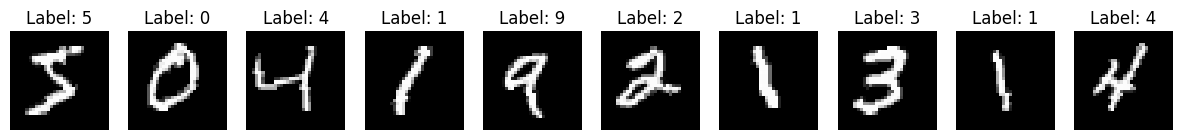

Max value: tensor(2.8215, device='cuda:0')
Min value: tensor(-0.4242, device='cuda:0')


In [3]:
dataset = datasets.MNIST(root='../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.MNIST(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)

# Used to pad the images from 28x28 to 32x32
# So the UNet can work with it.
# 32x32 is divisible by 2 multiple times, whereas 28x28 is not.
class PadTransform(object):
    def __call__(self, tensor):
        return F.pad(tensor, (2,2,2,2), mode='constant', value=0)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    PadTransform(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.Normalize((0.1307,), (0.3081,)),
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    PadTransform(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

train_set = PreloadedDataset.from_dataset(dataset, train_transform, device)

# Show example images
fig, axes = plt.subplots(1, 10, figsize=(15,5))
for i, ax in enumerate(axes):
    img, label = train_set[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.show()

# print max and min values
print('Max value:', train_set.transformed_images.max())
print('Min value:', train_set.transformed_images.min())

In [4]:
IMG_SIZE = 32
BATCH_SIZE = 64

# Values for closed form
T = 300
BETA_0 = 0.0001
BETA_T = 0.02
BETAS = linear_beta_schedule(T, BETA_0, BETA_T)

ALPHAS = 1.0 - BETAS
ALPHAS_CUMPROD = torch.cumprod(ALPHAS, dim=0)
ALPHAS_CUMPROD_PREV = F.pad(ALPHAS_CUMPROD[:-1], (1, 0), value=1.0)
SQRT_RECIP_ALPHAS = torch.sqrt(1.0 / ALPHAS)
SQRT_ALPHAS_CUMPROD = torch.sqrt(ALPHAS_CUMPROD)
SQRT_ONE_MINUS_ALPHAS_CUMPROD = torch.sqrt(1.0 - ALPHAS_CUMPROD)
POSTERIOR_VARIANCE = BETAS * (1.0 - ALPHAS_CUMPROD_PREV) / (1.0 - ALPHAS_CUMPROD)

In [5]:
def train(
        model,
        train_set,
        optimiser,
        criterion,
        losses = [],
        num_epochs=10,
):
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    for epoch in range(num_epochs):
        train_set.apply_transform()

        epoch_loss = 0.0
        loop = tqdm(train_loader, total=len(train_loader), leave=False)

        for data, _ in loop:

            # ts = torch.randint(0, T, (data.shape[0],1), device=device).long()
            ts = torch.randint(0, T, (data.shape[0],), device=device).long()
            noisy, noise = forward_diffusion_sample(data, ts.to('cpu'), SQRT_ALPHAS_CUMPROD, SQRT_ONE_MINUS_ALPHAS_CUMPROD, device)
            y_p = model(noisy, ts)

            loss = criterion(y_p, noise)

            epoch_loss += loss.item()

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            if epoch > 0:
                loop.set_postfix(loss=losses[-1])

        losses.append(epoch_loss / len(train_loader))
    return losses

In [6]:
model = UNet(
    BETAS,
    SQRT_ALPHAS_CUMPROD,
    SQRT_ONE_MINUS_ALPHAS_CUMPROD,
    SQRT_RECIP_ALPHAS,
    POSTERIOR_VARIANCE,
    T,
).to(device)
optimiser = torch.optim.AdamW(model.parameters(), lr=0.00034)
# L1 loss is the mean absolute error
# criterion = torch.nn.L1Loss()
criterion = torch.nn.MSELoss()
losses = []

In [14]:
losses = train(model, train_set, optimiser, criterion, losses, num_epochs=100)

Text(0.5, 0, 'Epoch')

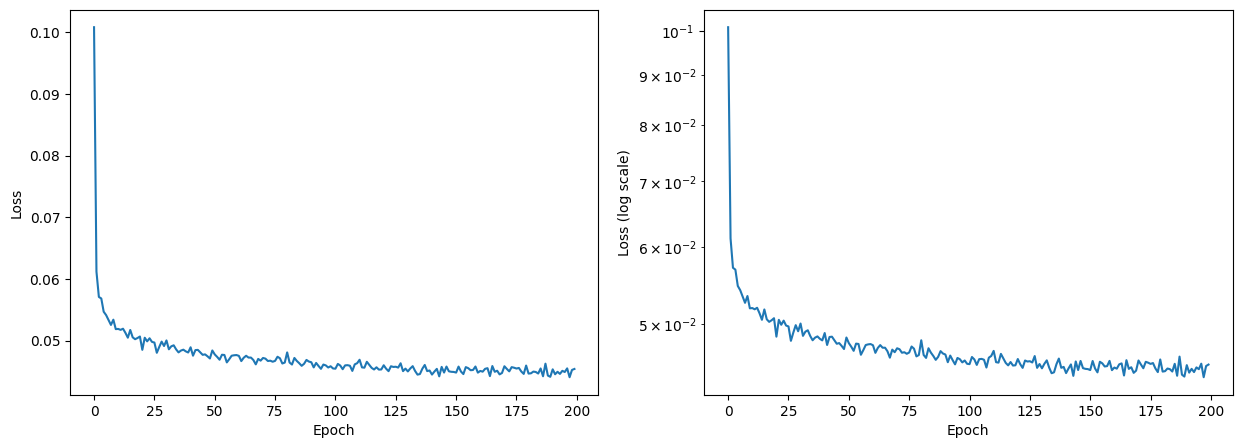

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(122)
plt.plot(losses)
plt.yscale('log')
plt.ylabel('Loss (log scale)')
plt.xlabel('Epoch')

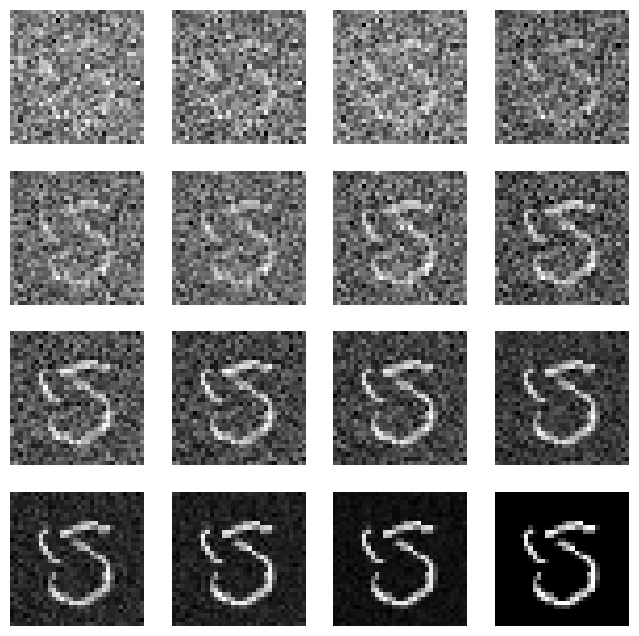

In [16]:
samples = model.sample_steps(15)[4:]
showExamples(samples)

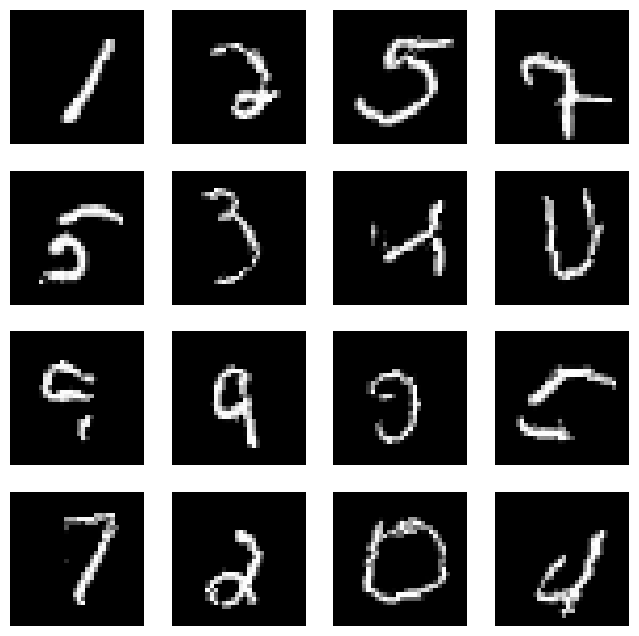

In [21]:
samples = model.sample()
showExamples(samples)